In [35]:
# Cargo todas las librerias necesarias para el modelo
import pandas as pd
import math
import time
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import mifs
from abc import ABCMeta, abstractmethod

In [26]:
def create_dataset(dataset,look_back):
    k=np.shape(dataset)[0]
    dataset=dataset.reshape(1,k)
    datax=np.zeros((k-look_back-23,look_back))
    for i in range(0,look_back,1):
        datax[:,i]=dataset[:,i:(k-look_back+i-23)]
    dataY=np.zeros((k-look_back-23,24))
    for i in range(0,24,1):
        dataY[:,i]=dataset[:,(look_back+i):(k-23+i)]
    return datax,dataY
def Kerfun(X,Z,p1,p2,u1,u2):
    if X.shape[1]!= Z.shape[1]:
        K=[]
        display('The second dimensions for X and Z must be agree.')
        return K
    X1=np.tile((((X*X).sum(axis=1)).reshape(X.shape[0],1)),(1,Z.shape[0]))
    Z1=np.tile((((Z*Z).sum(axis=1)).reshape(1,Z.shape[0])),(X.shape[0],1))
    rbf=(1-u1-u2)*np.exp(np.dot(-p1,(X1+Z1-np.dot(np.dot(2,X),Z.T))))
    poly=u2*((np.dot(X,Z.T) + 1) ** p2)
    line=u1*np.dot(X,Z.T)
    K=rbf+poly+line
    return K
def MLSSVRTrain(trnX,trnY,gamma,p,p1,u1,u2):
    if (trnX.shape[0] != trnY.shape[0]):
        display('The number of rows in trnX and trnY must be equal.')
        return v,b    
    l,m=trnY.shape
    K=Kerfun(trnX,trnX,p,p1,u1,u2)
    D1=np.c_[K/gamma,np.zeros((l,1))]
    D=np.r_[D1,np.zeros((1,l+1))]
    G=np.c_[K,np.ones((l,1))]
    A=D+np.dot(G.T,G) #+np.eye(l+1)
    P=np.linalg.solve(A,np.dot(G.T,trnY))
    v=P[0:l]
    b = P[l]
    return b,v
def MLSSVRPredict(tstX,tstY,trnX,v,b,p,p1,u1,u2):   
    if (tstY.shape[1] != len(b)):
        display('The number of column in tstY and b must be equal.')
        return predictY,MSE
    m=tstY.shape[1]
    l=trnX.shape[0]
    if (v.shape[0] != l or v.shape[1]!= m):
        display('The size of alpha should be ' + l + '*' + m)
        return predictY,MSE
    tstN=tstX.shape[0]
    b=b.flatten('F')
    K=Kerfun(tstX,trnX,p,p1,u1,u2)
    predictY=np.dot(K,v) + np.tile(b.T,(tstN,1))
    MSE=max(pow((predictY-tstY),2).sum(axis=1))
    #MSE=np.mean(pow((predictY-tstY),2))
    return predictY,MSE

In [28]:
def func_transformer(func):
    prefered_function_format = '''
    def demo_func(trainX,validX,trainy,validy,gamma,lambde,p,u1,u2):
        b,alpha=MLSSVRTrain(trainX,trainy,gamma,lambde,p,u1,u2)
        tmpY,MSE=MLSSVRPredict(validX,validy,trainX,alpha,b,lambde,p,u1,u2)
        return MSE
    '''
    is_vector = getattr(func, 'is_vector', False)
    if is_vector:
        return func
    else:
        if func.__code__.co_argcount == 1:
            def func_transformed(X):
                return np.array([func(x) for x in X])

            return func_transformed
        elif func.__code__.co_argcount > 1:

            def func_transformed(X):
                return np.array([func(*tuple(x)) for x in X])

            return func_transformed

    raise ValueError('''
    object function error,
    function should be like this:
    ''' + prefered_function_format)
class SkoBase(metaclass=ABCMeta):
    def register(self, operator_name, operator, *args, **kwargs):
        def operator_wapper(*wrapper_args):
            return operator(*(wrapper_args + args), **kwargs)
        setattr(self, operator_name, types.MethodType(operator_wapper, self))
        return self
class PSO1(SkoBase):
    def __init__(self, func, dim, pop=40, max_iter=150, lb=None, ub=None,T0=3,Tg=5,Tgz=10,w=0.8, c1=2, c2=2):
        self.func = func_transformer(func)
        self.w = w
        self.cp, self.cg = c1, c2  # parameters to control personal best, global best respectively
        self.pop = pop  # number of particles
        self.dim = dim  # dimension of particles, which is the number of variables of func
        self.max_iter = max_iter  # max iter
        self.T0=T0*np.ones((self.pop,1))
        self.Tg=Tg
        self.has_constraints = not (lb is None and ub is None)
        self.lb = -np.ones(self.dim) if lb is None else np.array(lb)
        self.ub = np.ones(self.dim) if ub is None else np.array(ub)
        assert self.dim == len(self.lb) == len(self.ub), 'dim == len(lb) == len(ub) is not True'
        assert np.all(self.ub > self.lb), 'upper-bound must be greater than lower-bound'

        self.X = np.random.uniform(low=self.lb, high=self.ub, size=(self.pop, self.dim))
        for i in range(self.pop):
            if self.X[i,3]+self.X[i,4]>1:
                self.X[i,4]=np.random.uniform(low=0,high=1-self.X[i,3],size=(1,1))
        self.X[:,2]=np.round(self.X[:,2])
        self.Y = self.cal_y()  # y = f(x) for all particles
        self.pbest_x = self.X.copy()  # personal best location of every particle in history
        self.pbest_y = self.Y.copy()  # best image of every particle in history
        self.gbest_x = np.zeros((1, self.dim))  # global best location for all particles
        self.gbest_y = np.inf  # global best y for all particles
        self.gbest_y_hist = []  # gbest_y of every iteration
        self.tg=0
        self.t0= np.zeros((self.pop,1))
        self.update_gbest()
        # record verbose values
        self.record_mode = False
        self.record_value = {'X': [],'Y': []}
    def update_X(self):
        #r3= np.where(self.t0 >self.T0, np.random.rand(self.pop, self.dim),1)
        r3= np.where(self.t0 >self.T0, \
            np.random.uniform(low=0,high=1,size=(self.pop, self.dim)),1)
        r4= np.where(self.tg >self.Tg,\
            np.random.uniform(low=0,high=1,size=(1,self.dim)),1)
        r1 = np.random.rand(self.pop, self.dim)
        r2 = np.random.rand(self.pop, self.dim)
        self.X=self.w *self.X+self.cp*r1*(r3*self.pbest_x-self.X)+\
               self.cg*r2*(r4*self.gbest_x - self.X)
        for i in range(self.pop):
            if self.X[i,3]+self.X[i,4]>1:
                self.X[i,4]=np.random.uniform(low=0,high=1-self.X[i,3],size=(1,1))
        self.X[:,2]=np.round(self.X[:,2])
        if self.has_constraints:
            self.X = np.clip(self.X, self.lb, self.ub)
    def cal_y(self):
        # calculate y for every x in X
        self.Y = self.func(self.X).reshape(-1, 1)
        return self.Y

    def update_pbest(self):
        self.t0 = np.where(self.pbest_y > self.Y,0,self.t0+1)
        #print("self.t0",self.t0)
        self.pbest_x = np.where(self.pbest_y > self.Y, self.X, self.pbest_x)
        self.pbest_y = np.where(self.pbest_y > self.Y, self.Y, self.pbest_y)
        #print("self.pbest_x",self.pbest_x)
    def update_gbest(self):
        self.tg=self.tg+1
        if self.gbest_y > self.pbest_y.min():
            self.gbest_x = self.pbest_x[self.pbest_y.argmin(), :].copy()
            self.gbest_y = self.pbest_y.min()
            self.tg=0
    def recorder(self):
        if not self.record_mode:
            return
        self.record_value['X'].append(self.X)
        self.record_value['Y'].append(self.Y)

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for iter_num in range(self.max_iter):
            self.recorder()
            self.update_X()
            self.cal_y()
            self.update_pbest()
            self.update_gbest()
            self.gbest_y_hist.append(self.gbest_y)
            #self.w=self.wi-(self.wi-self.we)*(iter_num/self.max_iter)**2
        return self

    fit = run

In [15]:
def demo_func(gamma,lambde,p,u1,u2):
    b,alpha=MLSSVRTrain(trainX,trainy,gamma,lambde,p,u1,u2)
    tmpY,MSE=MLSSVRPredict(validX,validy,trainX,alpha,b,lambde,p,u1,u2)
    #print(MSE)
    return MSE
#特征选择
def mrmry(trainx,trainy):
    x=trainx
    mrmr=[167]
    for i in range(0,24,4):
        y=trainy[:,i]
        feat_selector = mifs.MutualInformationFeatureSelector(method='MRMR',n_features=6,categorical=False)
        s=feat_selector.fit(x,y)
        mrmr=set(s.ranking_) | set(mrmr)
    return mrmr

In [29]:
def mulkMIMO(trainX,validX,testX,trainy,validy,testy):
    pso=PSO1(func=demo_func,dim=5,pop=20,max_iter=100,lb=[0.001, 0.001,1,0.01,0.0001],ub=[1000, 1000,10,1,1],w=0.8,c1=2,c2=2)
    pso.run()
    b,a=MLSSVRTrain(trainX,trainy,pso.gbest_x[0],pso.gbest_x[1],pso.gbest_x[2],pso.gbest_x[3],pso.gbest_x[4])
    pred,Mst=MLSSVRPredict(testX,testy,trainX,a,b,pso.gbest_x[1],pso.gbest_x[2],pso.gbest_x[3],pso.gbest_x[4])
    return pred
   

In [30]:
imf1 = pd.read_csv("C:/Users/Administrator/Desktop/data/imf1.csv").values
imf2 = pd.read_csv("C:/Users/Administrator/Desktop/data/imf2.csv").values
imf3 = pd.read_csv("C:/Users/Administrator/Desktop/data/imf3.csv").values
imf4 = pd.read_csv("C:/Users/Administrator/Desktop/data/imf4.csv").values
imf5 = pd.read_csv("C:/Users/Administrator/Desktop/data/imf5.csv").values
imf6 = pd.read_csv("C:/Users/Administrator/Desktop/data/imf6.csv").values
look_back=168
trainximf1,trainyimf1=create_dataset(imf1[0:672],look_back)
validximf1,validyimf1=create_dataset(imf1[480:912],look_back)
testximf1,testyimf1=create_dataset(imf1[720:1009],look_back)#12月1号

trainximf2,trainyimf2=create_dataset(imf2[0:672],look_back)
validximf2,validyimf2=create_dataset(imf2[480:912],look_back)
testximf2,testyimf2=create_dataset(imf2[720:1009],look_back)#12月1号

trainximf3,trainyimf3=create_dataset(imf3[0:672],look_back)
validximf3,validyimf3=create_dataset(imf3[480:912],look_back)
testximf3,testyimf3=create_dataset(imf3[720:1009],look_back)#12月1号

trainximf4,trainyimf4=create_dataset(imf4[0:672],look_back)
validximf4,validyimf4=create_dataset(imf4[480:912],look_back)
testximf4,testyimf4=create_dataset(imf4[720:1009],look_back)#12月1号

trainximf5,trainyimf5=create_dataset(imf5[0:672],look_back)
validximf5,validyimf5=create_dataset(imf5[480:912],look_back)
testximf5,testyimf5=create_dataset(imf5[720:1009],look_back)#12月1号

trainximf6,trainyimf6=create_dataset(imf6[0:672],look_back)
validximf6,validyimf6=create_dataset(imf6[480:912],look_back)
testximf6,testyimf6=create_dataset(imf6[720:1009],look_back)#12月1号
for i in range(0,9,1):
    mrmr={65, 2, 69, 6, 71, 74, 10, 11, 78, 14, 15, 18, 19, 23, 87, 156, 95, 159, 163, \
      164, 165, 166, 167, 39, 106, 43, 45, 47, 49, 53}
    trainX=trainximf1[:,list(mrmr)]
    validX=validximf1[:,list(mrmr)]
    testX=testximf1[:,list(mrmr)]
    trainy=trainyimf1
    validy=validyimf1
    testy=testyimf1
    pred=mulkMIMO(trainX,validX,testX,trainy,validy,testy,look_back)
    dt = pd.DataFrame(pred)
    url="C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF1MKMIMO"+str(i)+".csv"
    dt.to_csv(url, index=0)
    mrmr={0, 3, 4, 7, 8, 11, 12, 15, 16, 145, 19, 20, 28, 156, 32, 160, 161,\
      164, 36, 165, 167, 166, 110, 111, 114, 115}
    trainX=trainximf2[:,list(mrmr)]
    validX=validximf2[:,list(mrmr)]
    testX=testximf2[:,list(mrmr)]
    trainy=trainyimf2
    validy=validyimf2
    testy=testyimf2
    pred=mulkMIMO(trainX,validX,testX,trainy,validy,testy,look_back)
    dt = pd.DataFrame(pred)
    url="C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF2MKMIMO"+str(i)+".csv"
    dt.to_csv(url, index=0)
    mrmr={0, 4, 6, 8, 10, 12, 14, 16, 20, 150, 152, 154, 28, 30, 32, 162, 164, 36, 166, 167, 40, 44, \
      64, 68, 72, 76, 80, 97, 101, 105, 109}
    trainX=trainximf3[:,list(mrmr)]
    validX=validximf3[:,list(mrmr)]
    testX=testximf3[:,list(mrmr)]
    trainy=trainyimf3
    validy=validyimf3
    testy=testyimf3
    pred=mulkMIMO(trainX,validX,testX,trainy,validy,testy,look_back)
    dt = pd.DataFrame(pred)
    url="C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF3MKMIMO"+str(i)+".csv"
    dt.to_csv(url,index=0)
    mrmr={0, 2, 4, 6, 7, 8, 12, 13, 16, 17, 144, 20, 148, 152, 24, 156, 28, 32,\
      163, 36, 164, 165, 167, 166, 40, 44, 64, 68, 77, 81, 85, 89, 93}
    trainX=trainximf4[:,list(mrmr)]
    validX=validximf4[:,list(mrmr)]
    testX=testximf4[:,list(mrmr)]
    trainy=trainyimf4
    validy=validyimf4
    testy=testyimf4
    pred=mulkMIMO(trainX,validX,testX,trainy,validy,testy,look_back)
    dt = pd.DataFrame(pred)
    url="C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF4MKMIMO"+str(i)+".csv"
    dt.to_csv(url,index=0)
    mrmr={128, 1, 0, 132, 5, 4, 136, 9, 8, 140, 13, 12, 16, 144, 20, 148, 152, 24,\
      156, 28, 160, 32, 163, 164, 36, 166, 167, 40, 44, 51, 66, 80, 96, 98, 124}
    trainX=trainximf5[:,list(mrmr)]
    validX=validximf5[:,list(mrmr)]
    testX=testximf5[:,list(mrmr)]
    trainy=trainyimf5
    validy=validyimf5
    testy=testyimf5
    pred=mulkMIMO(trainX,validX,testX,trainy,validy,testy,look_back)
    dt = pd.DataFrame(pred)
    url="C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF5MKMIMO"+str(i)+".csv"
    dt.to_csv(url,index=0)
    mrmr={0,1,130,4,8,12,16,144,20,148,152,24,155,156,28,160,32,164,36,165,166,40,167,44,\
      64, 70, 80, 84, 95, 96, 99, 103, 107, 111, 124}
    trainX=trainximf6[:,list(mrmr)]
    validX=validximf6[:,list(mrmr)]
    testX=testximf6[:,list(mrmr)]
    trainy=trainyimf6
    validy=validyimf6
    testy=testyimf6
    pred=mulkMIMO(trainX,validX,testX,trainy,validy,testy,look_back)
    dt = pd.DataFrame(pred)
    url="C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF6MKMIMO"+str(i)+".csv"
    dt.to_csv(url,index=0)
    print(i)

0
1
2
3
4
5
6
7
8


In [31]:
imf1MKMIMO = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF1MKMIMO1.csv").values
imf2MKMIMO = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF2MKMIMO1.csv").values
imf3MKMIMO = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF3MKMIMO1.csv").values
imf4MKMIMO = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF4MKMIMO1.csv").values
imf5MKMIMO = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF5MKMIMO1.csv").values
imf6MKMIMO = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF6MKMIMO1.csv").values

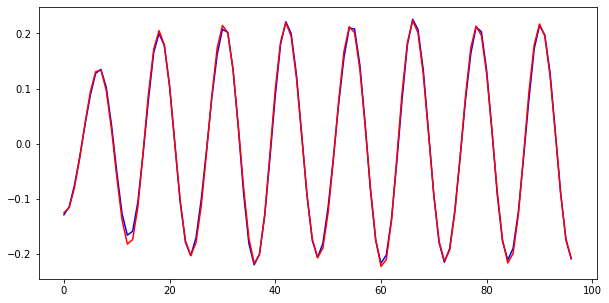

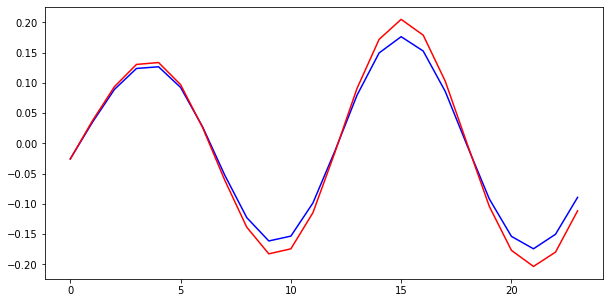

In [34]:
plt.figure(figsize=(10,5))
plt.plot(imf3MKMIMO[:,1],color="blue")
plt.plot(testyimf3[:,1],color="red")
plt.figure(figsize=(10,5))
plt.plot(imf3MKMIMO[4],color="blue")
plt.plot(testyimf3[4],color="red")

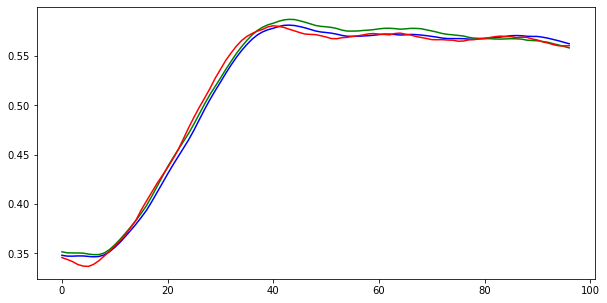

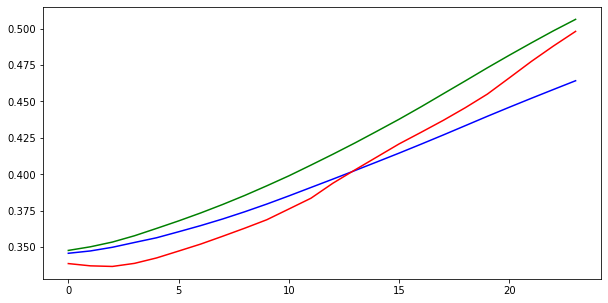

In [38]:
imf1d1 = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF1d1.csv").values
imf1t1 = pd.read_csv("C:/Users/Administrator/Desktop/data/电力负荷预测/t检验/IMF1t1.csv").values
plt.figure(figsize=(10,5))
plt.plot(imf1d1[:,1],color="blue")
plt.plot(imf1t1[:,1],color="green")
plt.plot(testyimf1[:,1],color="red")
plt.figure(figsize=(10,5))
plt.plot(imf1d1[4],color="blue")
plt.plot(imf1t1[4],color="green")
plt.plot(testyimf1[4],color="red")
https://github.com/yuanfangy/Integrated-multi-step-strategy-for-power-load-forecasting.git